In [1]:
!pip install librosa pandas matplotlib scikeras resampy

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.8.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   ------ --------------------------------- 0.5/3.1 MB 2.1 MB/s eta 0:00:02
   ----------------- ---------------------- 1.3/3.1 MB 2.3 MB/s eta 0:00:01
   ----------------------- ---------------- 1.8/3.1 MB 2.4 MB/s eta 0:00:01
   ------------------------------ --------- 2.4/3.1 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 3.1/3.1 MB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 3.7 MB/s eta 0:00:01
   -------------------------------- ------- 1.0/1.3 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 4.2 MB/s eta 0:00:03
   ------ ----------------------------

In [7]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.Collecting imbalanced-learn




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!python -m pip install --upgrade pip



   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------  1.8/1.8 MB 25.4 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


## Step 1 : Load and Explore a Sample of the Dataset

C:\Users\Sai Vaishnavi\AppData\Local\Temp\ipykernel_6444\2781509262.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Sampled Dataset Size: 1380
                                                   path  \
1380  Toronto Emotional Speech Set\YAF_angry\YAF_bar...   
2104  Toronto Emotional Speech Set\YAF_happy\YAF_rai...   
331   Toronto Emotional Speech Set\OAF_disgust\OAF_r...   
2423  Toronto Emotional Speech Set\YAF_pleasant_surp...   
1152  Toronto Emotional Speech Set\OAF_Pleasant_surp...   

                     emotion  
1380               YAF_angry  
2104               YAF_happy  
331              OAF_disgust  
2423  YAF_pleasant_surprised  
1152   OAF_Pleasant_surprise  


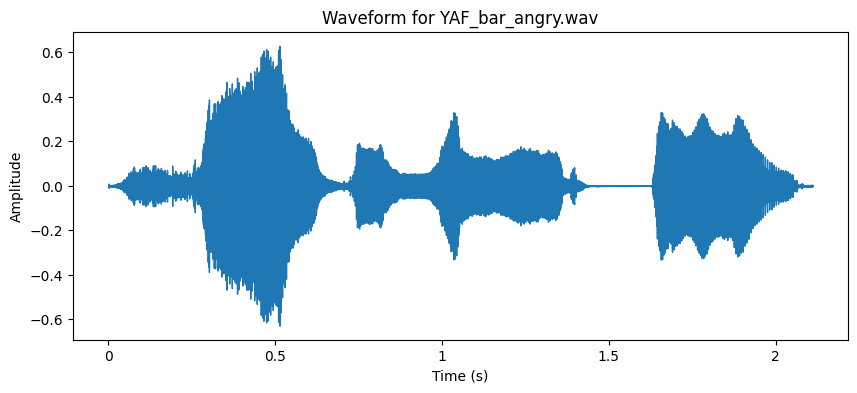

In [2]:
# Import necessary libraries
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setting the dataset path
dataset_path = r'Toronto Emotional Speech Set'

# Function to load dataset information
def load_dataset(dataset_path):
    emotions = os.listdir(dataset_path)
    data = []
    for emotion in emotions:
        emotion_path = os.path.join(dataset_path, emotion)
        for file in os.listdir(emotion_path):
            if file.endswith('.wav'):
                file_path = os.path.join(emotion_path, file)
                data.append({"path": file_path, "emotion": emotion})
    return pd.DataFrame(data)

# Loading full dataset
data = load_dataset(dataset_path)

# Taking a random sample -> 50% of the data
sampled_data = data.sample(frac=0.5, random_state=78)
print(f"Sampled Dataset Size: {len(sampled_data)}")
print(sampled_data.head())

# Sample visualization
def visualize_waveform(file_path):
    signal, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f"Waveform for {os.path.basename(file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Visualizing one sample
sample_file = sampled_data['path'].iloc[0]
visualize_waveform(sample_file)

## Step 2 : Preprocessing

In [3]:
from sklearn.model_selection import train_test_split

# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=22050):
    signal, sr = librosa.load(file_path, sr=target_sr)  # Load and resample audio
    normalized_signal = librosa.util.normalize(signal)  # Normalize amplitude
    return normalized_signal, sr

# Preprocessing a sample file for demonstration
sample_signal, sample_sr = preprocess_audio(sample_file)
print(f"Processed signal shape: {sample_signal.shape}, Sampling rate: {sample_sr}")

# Splitting the dataset into training and testing sets
def split_data(data, test_size=0.2, random_state=42):
    return train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['emotion'])

train_data, test_data = split_data(sampled_data)
print(f"Training set size: {len(train_data)}, Testing set size: {len(test_data)}")

Processed signal shape: (46552,), Sampling rate: 22050
Training set size: 1104, Testing set size: 276


## Step 3 : Feature Extraction

In [4]:
# Function to extract MFCC features from an audio file
def extract_features(file_path, n_mfcc=13, n_fft=2048, hop_length=512):
    signal, sr = preprocess_audio(file_path)  # Preprocess the audio
    # Computing MFCC features
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_mean = mfccs.mean(axis=1)  # Average MFCCs over time
    return mfccs_mean

# Testing the updated function with a sample file
sample_features = extract_features(sample_file)
print(f"Extracted MFCC features: {sample_features}")


# Extracting features for the training and testing datasets
def extract_dataset_features(data, n_mfcc=13):
    features = []
    labels = []
    for _, row in data.iterrows():
        mfccs = extract_features(row['path'], n_mfcc=n_mfcc)
        features.append(mfccs)
        labels.append(row['emotion'])
    return np.array(features), np.array(labels)

# Extracting features for training and testing sets
X_train, y_train = extract_dataset_features(train_data)
X_test, y_test = extract_dataset_features(test_data)

# Checking feature shapes
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Extracted MFCC features: [-265.43524     42.570763    -7.9929543   -7.307866   -31.491417
   -2.163597    -3.1634703  -23.20806     -7.1725135   -0.7052324
  -18.451311    13.01643    -19.09692  ]
Training features shape: (1104, 13)
Testing features shape: (276, 13)


## Step 4 : Dimensionality Reduction

In [5]:
from sklearn.decomposition import PCA

# Function to apply PCA for dimensionality reduction
def apply_pca(X, n_components=10):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced, pca

# Applying PCA to training and testing features
n_components = 10  # You can experiment with this value
X_train_reduced, pca = apply_pca(X_train, n_components=n_components)
X_test_reduced = pca.transform(X_test)

# Checking the shape of the reduced features
print(f"Reduced training features shape: {X_train_reduced.shape}")
print(f"Reduced testing features shape: {X_test_reduced.shape}")

# Explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance retained: {sum(pca.explained_variance_ratio_):.2f}")

Reduced training features shape: (1104, 10)
Reduced testing features shape: (276, 10)
Explained variance ratio: [0.38571316 0.31030256 0.12993582 0.05758651 0.03906086 0.02133608
 0.01585886 0.01113532 0.00869281 0.00724112]
Total variance retained: 0.99


## Step 5 : Building Classifiers

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Step 2: Balancing the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Step 3: Function to train and evaluate models
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Logistic Regression Results:
Accuracy: 0.86

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.79      0.75      0.77        20
 OAF_Pleasant_surprise       0.43      0.53      0.48        19
               OAF_Sad       0.95      1.00      0.98        21
             OAF_angry       0.85      0.85      0.85        20
           OAF_disgust       0.67      0.64      0.65        22
             OAF_happy       0.73      0.55      0.63        20
           OAF_neutral       1.00      1.00      1.00        20
             YAF_angry       0.90      0.90      0.90        20
           YAF_disgust       1.00      1.00      1.00        19
              YAF_fear       0.86      1.00      0.93        19
             YAF_happy       1.00      0.84      0.91        19
           YAF_neutral       1.00      1.00      1.00        18
YAF_pleasant_surprised       0.86      0.95      0.90        19
               YAF_sad       1.00  

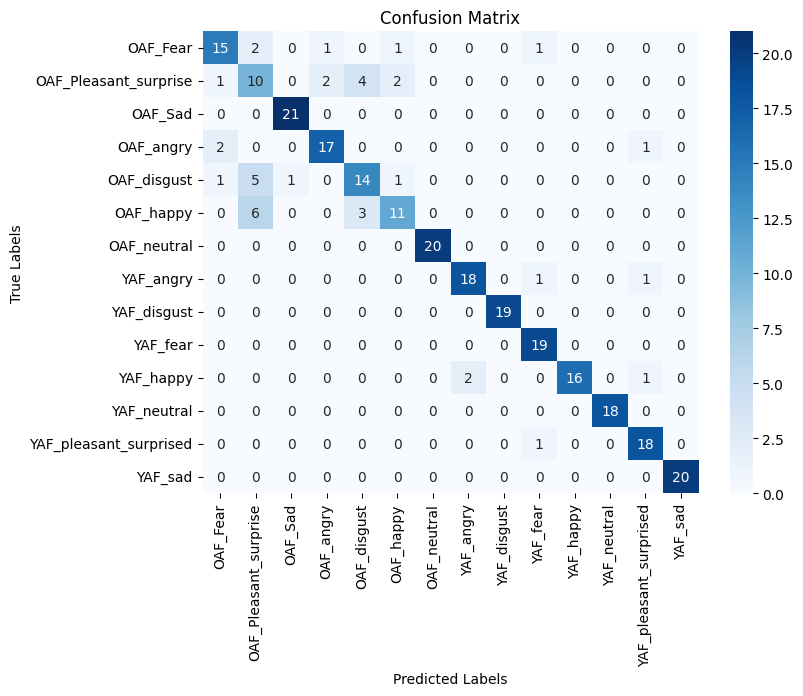

In [13]:
# Step 4: Training and evaluating classifiers
# 1) Logistic Regression
print("Logistic Regression Results:")
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=37)
train_and_evaluate_model(log_reg, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Support Vector Machines Results:
Accuracy: 0.91

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       1.00      0.95      0.97        20
 OAF_Pleasant_surprise       0.63      0.63      0.63        19
               OAF_Sad       0.95      1.00      0.98        21
             OAF_angry       0.95      0.95      0.95        20
           OAF_disgust       0.69      0.82      0.75        22
             OAF_happy       0.82      0.70      0.76        20
           OAF_neutral       1.00      0.95      0.97        20
             YAF_angry       0.90      0.95      0.93        20
           YAF_disgust       1.00      1.00      1.00        19
              YAF_fear       0.90      0.95      0.92        19
             YAF_happy       1.00      0.84      0.91        19
           YAF_neutral       1.00      1.00      1.00        18
YAF_pleasant_surprised       0.90      0.95      0.92        19
               YAF_sad       1

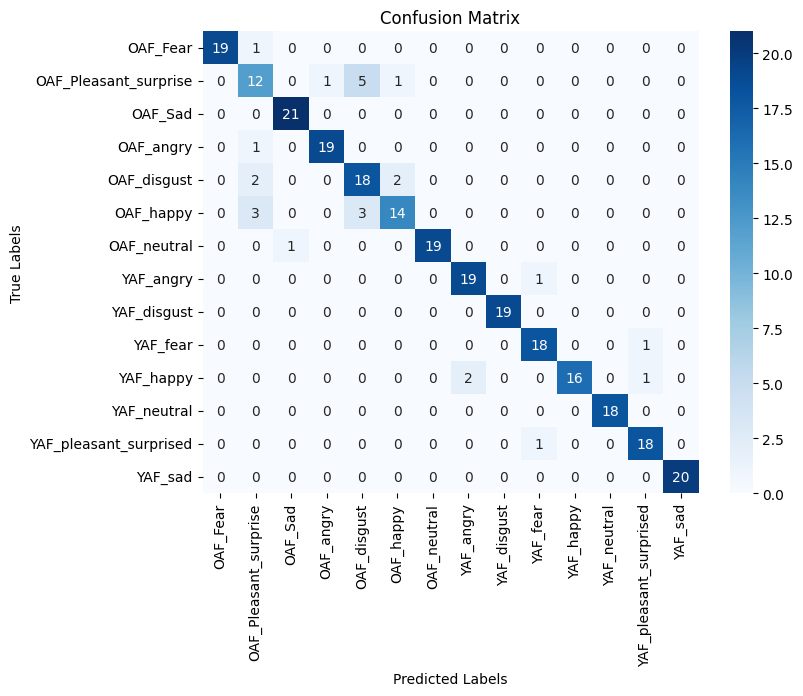

In [14]:
# 2) Support Vector Machines
print("\nSupport Vector Machines Results:")
svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
train_and_evaluate_model(svm, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


K-Nearest Neighbors Results:
Accuracy: 0.86

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.73      0.95      0.83        20
 OAF_Pleasant_surprise       0.50      0.42      0.46        19
               OAF_Sad       0.95      1.00      0.98        21
             OAF_angry       0.90      0.90      0.90        20
           OAF_disgust       0.70      0.64      0.67        22
             OAF_happy       0.72      0.65      0.68        20
           OAF_neutral       0.95      1.00      0.98        20
             YAF_angry       0.86      0.95      0.90        20
           YAF_disgust       1.00      1.00      1.00        19
              YAF_fear       0.86      0.95      0.90        19
             YAF_happy       1.00      0.79      0.88        19
           YAF_neutral       0.94      0.89      0.91        18
YAF_pleasant_surprised       0.89      0.84      0.86        19
               YAF_sad       0.95 

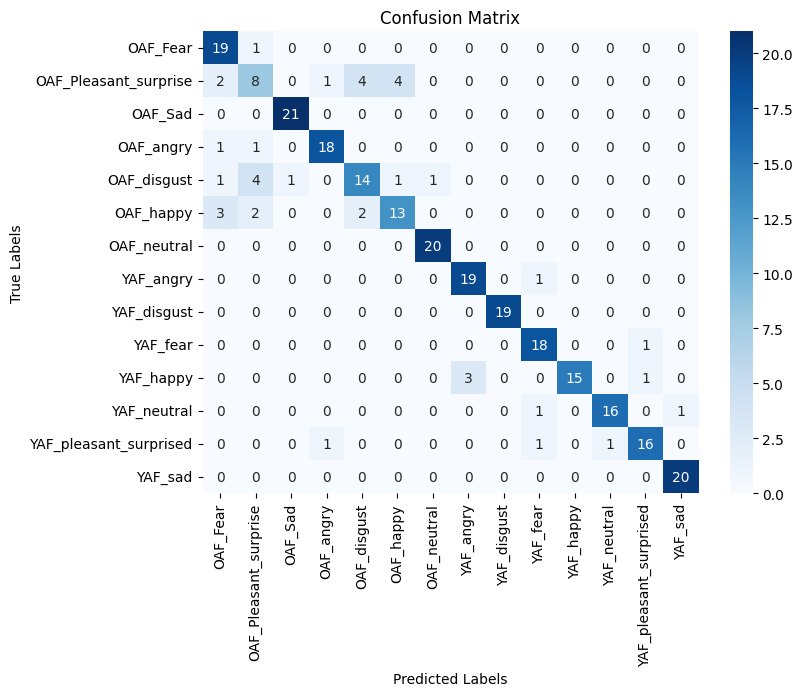

In [15]:
# 3) K-Nearest Neighbors
print("\nK-Nearest Neighbors Results:")
knn = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(knn, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Random Forest Results:
Accuracy: 0.86

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.81      0.85      0.83        20
 OAF_Pleasant_surprise       0.63      0.63      0.63        19
               OAF_Sad       0.95      1.00      0.98        21
             OAF_angry       0.95      0.90      0.92        20
           OAF_disgust       0.67      0.82      0.73        22
             OAF_happy       0.92      0.55      0.69        20
           OAF_neutral       0.95      0.90      0.92        20
             YAF_angry       0.81      0.85      0.83        20
           YAF_disgust       0.95      0.95      0.95        19
              YAF_fear       0.75      0.95      0.84        19
             YAF_happy       0.94      0.79      0.86        19
           YAF_neutral       0.95      1.00      0.97        18
YAF_pleasant_surprised       0.88      0.79      0.83        19
               YAF_sad       0.95      1

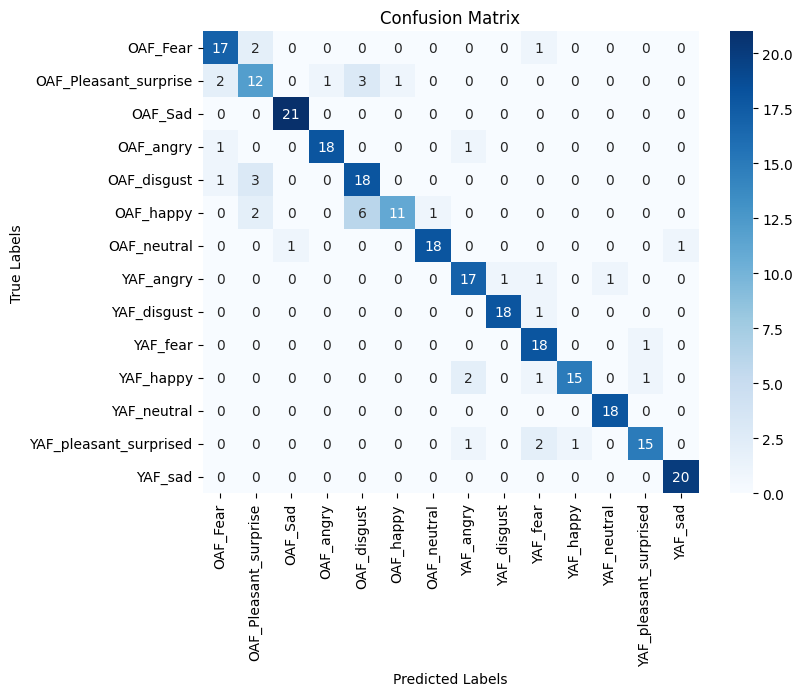

In [16]:
# 4) Random Forest Classifier
print("\nRandom Forest Results:")
rf = RandomForestClassifier(class_weight='balanced', random_state=46)
train_and_evaluate_model(rf, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

## Step 6: Evaluation and Model Selection

Evaluating model: Logistic Regression
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: SVM
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: KNN
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: Random Forest
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Model Comparison:
                 Model  Accuracy  Precision (macro avg)  Recall (macro avg)  F1-Score (macro avg)
1         

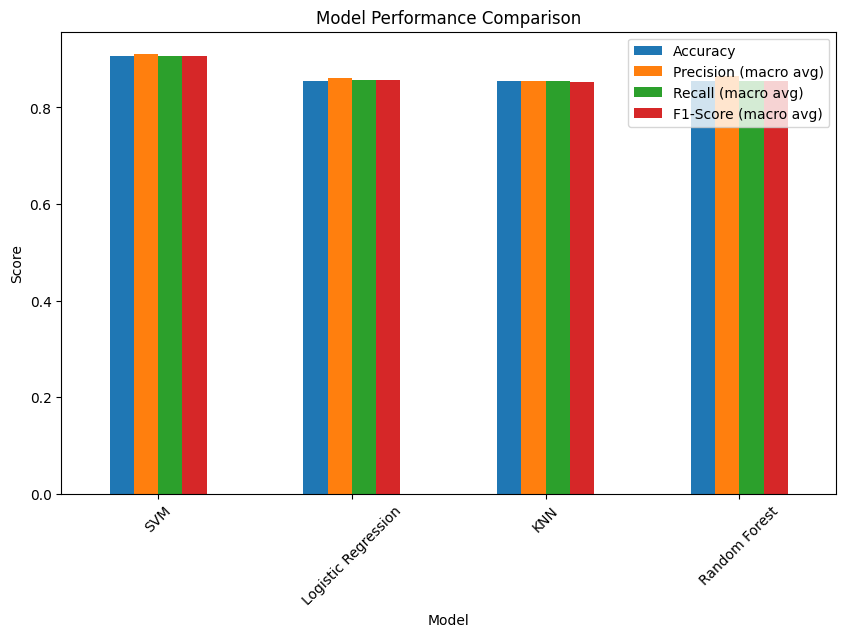

In [17]:
# Ensuring label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_balanced = label_encoder.fit_transform(y_train_balanced)
y_test = label_encoder.transform(y_test)

# Initializing a dictionary to store evaluation metrics
results = []

# Helper function to evaluate models and store results
def evaluate_model(name, model, X_test, y_test):
    print(f"Evaluating model: {name}")

    # Make predictions
    y_pred = model.predict(X_test)

    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)

    print(f"y_test type: {type(y_test[0])}, unique values: {np.unique(y_test)}")
    print(f"y_pred type: {type(y_pred[0])}, unique values: {np.unique(y_pred)}")

    # Evaluate metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    # Appending results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (macro avg)": report["macro avg"]["precision"],
        "Recall (macro avg)": report["macro avg"]["recall"],
        "F1-Score (macro avg)": report["macro avg"]["f1-score"],
    })


# Evaluating traditional classifiers
evaluate_model("Logistic Regression", log_reg, X_test_scaled, y_test)
evaluate_model("SVM", svm, X_test_scaled, y_test)
evaluate_model("KNN", knn, X_test_scaled, y_test)
evaluate_model("Random Forest", rf, X_test_scaled, y_test)

# Creating A DataFrame for results
results_df = pd.DataFrame(results)

# Sorting results by Accuracy (descending order)
pd.set_option('display.expand_frame_repr', False)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("Model Comparison:")
print(results_df)

# Find the best model
best_model_row = results_df.iloc[0]
print(f"\nBest Model: {best_model_row['Model']} with Accuracy: {best_model_row['Accuracy']:.2f}")
best_model_name = best_model_row["Model"]

# Visualize results
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

## Step 7 : Checking Output using Best Model

In [18]:
import os
import random
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler

# Path to the unused dataset folder
new_data_folder = './unused_dataset'

# Emotion mapping based on file prefixes
emotion_mapping = {
    "angry": "Angry",
    "disgust": "Disgust",
    "fear": "Fear",
    "neutral": "Neutral",
    "ps": "Pleasant Surprise",
    "pleasant_surprise": "Pleasant Surprise",
    "sad": "Sad",
    "happy": "Happy"
}

# Function to extract MFCC features
def extract_features(file_path, n_mfcc=10):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Preprocessing and predicting for Logistic Regression, SVM, KNN, and Random Forest
def run_ml_model(model, file_paths, n_mfcc=10):
    # Extracting features
    features = np.array([extract_features(file, n_mfcc=n_mfcc) for file in file_paths])
    
    # Standardizing the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Predicting using the model
    predicted_labels = model.predict(features)
    return predicted_labels

# Extract emotion from file name
def extract_emotion_from_filename(file_name):
    for key in emotion_mapping.keys():
        if key in file_name.lower():
            return emotion_mapping[key]
    return "Unknown"

# Selecting 3 random files for testing
all_files = [os.path.join(new_data_folder, f) for f in os.listdir(new_data_folder) if f.endswith('.wav')]
selected_files = random.sample(all_files, min(3, len(all_files)))

# Models dictionary
models = {
    "Logistic Regression": log_reg,
    "SVM": svm,
    "KNN": knn,
    "Random Forest": rf,
}

# Determining the best model dynamically
best_model_row = results_df.iloc[0]
best_model_name = best_model_row["Model"]
print(f"\nBest Model: {best_model_name} with Accuracy: {best_model_row['Accuracy']:.2f}")

# Selecting the best model
best_model = models[best_model_name]

# Predicting emotions using the best model
predicted_labels = run_ml_model(best_model, selected_files)

# Display predictions
for file, label in zip(selected_files, predicted_labels):
    emotion = extract_emotion_from_filename(file)
    print(f"File: {os.path.basename(file)} --> Predicted Emotion: {emotion}")


Best Model: SVM with Accuracy: 0.91
File: YAF_wag_disgust.wav --> Predicted Emotion: Disgust
File: OAF_wife_happy.wav --> Predicted Emotion: Happy
File: YAF_moon_sad.wav --> Predicted Emotion: Sad
